# PSTAT 100 Course Project: World Happiness Report Data Exploration
By: Mario Tapia-Pacheco

## Data Description

The dataset I chose to work with comes from The World Happiness Report, a publication that collects data on happiness rankings across the world. The data collected spans from 2008 to 2022 and is collected from 165 distinct countries; each sample is nationally representative. In order to measure happiness, respondents were asked several questions including a self-assessed happiness rating, whether or not they had donated in the past month, and whether or not they believed their government is corrupt. The self-assessed happiness rating is on a scale of 1-10 while all other questions are either 0 (respondent answered no, disagreed, or was unsatisfied) or 1 (respondent answered yes, agreed, or was satisfied). Other variables in the dataset measure factors such as life expectancy, log GDP per capita, postive affect, and negative affect. According to the World Health Report website, positive affect measures the average frequency of happiness, laughter and enjoyment on the previous day, while negative affect measures the average frequency of worry, sadness and anger on the previous day. A preview of the data can be found below.

In [22]:
whr_data.head()

,Country,Year,Happiness rating,Log GDP per capita,Social support,Life expectancy at birth,Freedom to make life choices,Generosity,Perceptions of corruption,Positive affect,Negative affect
0,Afghanistan,2008,3.724,7.350,0.451,50.5,0.718,0.168,0.882,0.414,0.258
1,Afghanistan,2009,4.402,7.509,0.552,50.8,0.679,0.191,0.850,0.481,0.237
2,Afghanistan,2010,4.758,7.614,0.539,51.1,0.600,0.121,0.707,0.517,0.275
3,Afghanistan,2011,3.832,7.581,0.521,51.4,0.496,0.164,0.731,0.480,0.267
4,Afghanistan,2012,3.783,7.661,0.521,51.7,0.531,0.238,0.776,0.614,0.268


## Question of Interest

For my data exploration, I will focus on discovering potential factors affecting happiness across the world. I will look into which countries have the happiest populations, which have the unhappiest, and if happier countries are consolidated to small areas or if they are more spread out. Among the countries of interest, are there any relationships that can be found between their happiness ranking and the political and economic state of their countries? Possible answers may lie in a country's economic status, respondents' perceptions of corruption, and the extent to which respondents have the freedom to make their own life choices.

## Data Analysis

In [1]:
import numpy as np
import pandas as pd
import altair as alt
import statsmodels.api as sm
from scipy import linalg
from statsmodels.multivariate.pca import PCA
alt.data_transformers.disable_max_rows()
alt.renderers.enable('mimetype')

RendererRegistry.enable('mimetype')

In [2]:
whr_data = pd.read_csv('data/whr-2023.csv')
whr_data.rename(columns={'Country name':'Country', 'year':'Year', 'Life Ladder':'Happiness rating',
                        'Healthy life expectancy at birth': 'Life expectancy at birth'},
               inplace = True)

In [3]:
whr_data.isnull().mean()

Country                         0.000000
Year                            0.000000
Happiness rating                0.000000
Log GDP per capita              0.009095
Social support                  0.005912
Life expectancy at birth        0.024557
Freedom to make life choices    0.015007
Generosity                      0.033197
Perceptions of corruption       0.052751
Positive affect                 0.010914
Negative affect                 0.007276
dtype: float64

All variables are almost completely nonmissing, so dealing with missing data is not an issue with this specific dataset. In order to get a general sense of what variables might be influencing happiness, we can start by constructing a correlation heatmap.

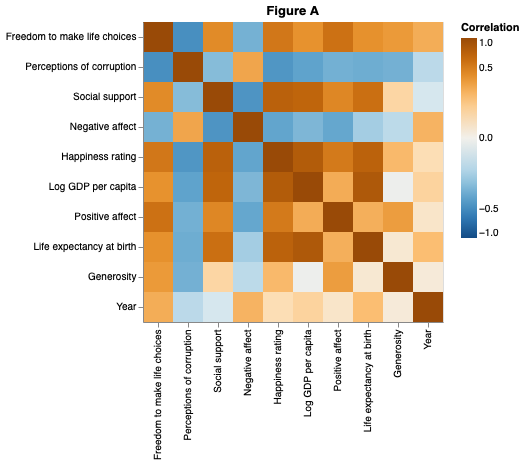

In [4]:
# construct correlation matrix
corr_mx = whr_data.drop(columns=['Country']).corr()

# melt corr_mx
corr_mx_long = corr_mx.reset_index().rename(
    columns = {'index': 'row'}
).melt(
    id_vars = 'row',
    var_name = 'col',
    value_name = 'Correlation'
)

# construct correlation heatmap
fig_a = alt.Chart(corr_mx_long, title = 'Figure A').mark_rect().encode(
    x = alt.X('col', title = '', sort = {'field': 'Correlation', 'order': 'ascending'}), 
    y = alt.Y('row', title = '', sort = {'field': 'Correlation', 'order': 'ascending'}),
    color = alt.Color('Correlation', 
                      scale = alt.Scale(scheme = 'blueorange', # diverging gradient
                                        domain = (-1, 1), # ensure white = 0
                                        type = 'sqrt'), # adjust gradient scale
                     legend = alt.Legend(tickCount = 5)) # add ticks to colorbar at 0.5 for reference
).properties(width = 300, height = 300)

# display
fig_a

In [5]:
# inspect happiness rating's individual correlation values with other variables
corr_mx.loc[:, 'Happiness rating'].sort_values()

Perceptions of corruption      -0.431500
Negative affect                -0.339969
Year                            0.045947
Generosity                      0.181630
Positive affect                 0.518169
Freedom to make life choices    0.534493
Life expectancy at birth        0.713499
Social support                  0.721662
Log GDP per capita              0.784868
Happiness rating                1.000000
Name: Happiness rating, dtype: float64

Based on this figure, happiness ratings seem to be strongly correlated with life expectancy, log GDP per capita, and whether or not a person has social support (people they can rely on in times of need). An interesting thing to notice is that perceptions of corruption is negatively correlated with almost every other variable; this can be a point of exploration further into the analysis. For now, we can focus on the strong correlations with happiness ratings and plot each respective variable with happiness ratings.

In [6]:
whr_data1 = whr_data.copy()

In [23]:
# construct scatterplot, happiness against life expectancy
fig_b1 = alt.Chart(whr_data, title = 'Figure B1').mark_circle(opacity = 0.3, color = '#0054d1').encode(
    x = alt.X('Life expectancy at birth', title = 'Life Expectancy at Birth', scale = alt.Scale(type='pow')),
    y = alt.Y('Happiness rating', title = 'Happiness Rating', scale = alt.Scale(zero=False)),
).properties(
    height = 263,
    width = 350
)

temp = whr_data1[['Happiness rating', 'Life expectancy at birth']].dropna()
y = temp['Happiness rating']

# construct the explanatory variable matrix
x = sm.tools.add_constant(temp['Life expectancy at birth']).dropna()

# fit model
slr = sm.OLS(endog = y, exog = x)
rslt = slr.fit()

temp['fitted_slr'] = rslt.fittedvalues
temp['resid_slr'] = rslt.resid

# construct line plot
slr_line = alt.Chart(temp).mark_line(color='#c4145d').encode(
    x = alt.X('Life expectancy at birth'),
    y = alt.Y('fitted_slr')
)

# construct band
preds = rslt.get_prediction(x)
temp['lwr_mean'] = preds.predicted_mean - 2*preds.se_mean
temp['upr_mean'] = preds.predicted_mean + 2*preds.se_mean
band = alt.Chart(temp).mark_area(opacity = 0.2, color='#c4145d').encode(
    x = 'Life expectancy at birth',
    y = 'lwr_mean',
    y2 = 'upr_mean'
)

In [24]:
# construct scatterplot, happiness against log gdp per capita
fig_b2 = alt.Chart(whr_data, title = 'Figure B2').mark_circle(opacity = 0.3, color = '#018c30').encode(
    x = alt.X('Log GDP per capita', scale = alt.Scale(type='pow', zero=False)),
    y = alt.Y('Happiness rating', title = 'Happiness Rating', scale = alt.Scale(zero=False)),
).properties(
    height = 263,
    width = 350
)

temp2 = whr_data1[['Happiness rating', 'Log GDP per capita']].dropna()
y = temp2['Happiness rating']

# construct the explanatory variable matrix
x2 = sm.tools.add_constant(temp2['Log GDP per capita'] - temp2['Log GDP per capita'].mean()).dropna()

# fit model
slr = sm.OLS(endog = y, exog = x2)
rslt = slr.fit()

temp2['fitted_slr'] = rslt.fittedvalues
temp2['resid_slr'] = rslt.resid

# construct line plot
slr_line2 = alt.Chart(temp2).mark_line(color='#c4145d').encode(
    x = alt.X('Log GDP per capita'),
    y = alt.Y('fitted_slr')
)

# construct band
preds = rslt.get_prediction(x2)
temp2['lwr_mean'] = preds.predicted_mean - 2*preds.se_mean
temp2['upr_mean'] = preds.predicted_mean + 2*preds.se_mean
band2 = alt.Chart(temp2).mark_area(opacity = 0.2, color='#c4145d').encode(
    x = 'Log GDP per capita',
    y = 'lwr_mean',
    y2 = 'upr_mean'
)

In [25]:
# construct scatterplot, happiness against social support
fig_b3 = alt.Chart(whr_data, title = 'Figure B3').mark_circle(opacity = 0.3, color = '#530ead').encode(
    x = alt.X('Social support', scale = alt.Scale(type='pow', zero=False)),
    y = alt.Y('Happiness rating', title = 'Happiness Rating', scale = alt.Scale(type='pow', zero=False)),
).properties(
    height = 263,
    width = 350
)

temp3 = whr_data1[['Happiness rating', 'Social support']].dropna()
y = temp3['Happiness rating']

# center the support column by subtracting its mean from each value
support = (temp3['Social support'] - temp3['Social support'].mean())

# construct the explanatory variable matrix
x3 = sm.tools.add_constant(support).dropna()

# fit model
slr = sm.OLS(endog = y, exog = x3)
rslt = slr.fit()

temp3['fitted_slr'] = rslt.fittedvalues
temp3['resid_slr'] = rslt.resid

# construct line plot
slr_line3 = alt.Chart(temp3).mark_line(color='#c4145d').encode(
    x = alt.X('Social support', scale = alt.Scale(type='pow')),
    y = alt.Y('fitted_slr', scale = alt.Scale(type='pow'))
)

# construct band
preds = rslt.get_prediction(x3)
temp3['lwr_mean'] = preds.predicted_mean - 2*preds.se_mean
temp3['upr_mean'] = preds.predicted_mean + 2*preds.se_mean
band3 = alt.Chart(temp3).mark_area(opacity = 0.2, color='#c4145d').encode(
    x = 'Social support',
    y = 'lwr_mean',
    y2 = 'upr_mean'
)

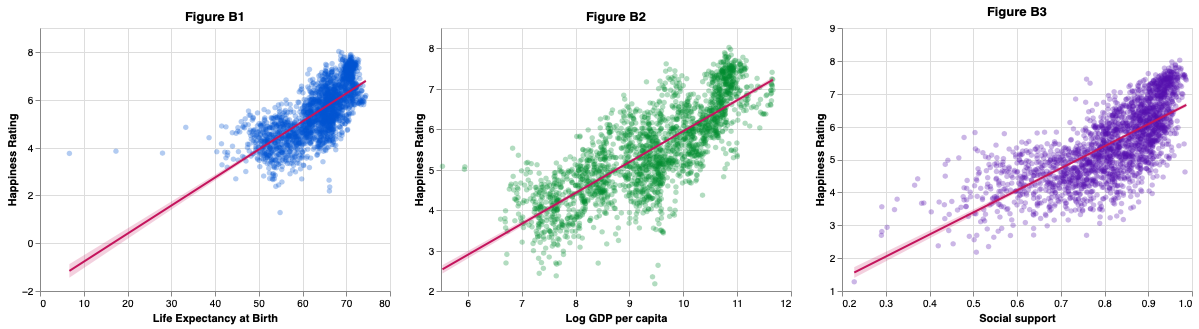

In [26]:
# display
(fig_b1 + slr_line + band) | (fig_b2 + slr_line2 + band2) | (fig_b3 + slr_line3 + band3)

Figures B1-B3 confirm the findings from Figure A, all three variables (life expectancy, GDP per capita, and social support) have a strong, positive correlation with the happiness rating of a country. Now, we can explore the countries with the highest and lowest happiness rankings.

In [11]:
# slice columns of interest and group by country
whr_1 = whr_data[['Country', 'Happiness rating', 
                  'Log GDP per capita', 'Social support', 
                  'Life expectancy at birth']].groupby('Country').mean().sort_values('Happiness rating')

# concatenate 15 lowest rated countries and 15 highest rated countries by happiness
lh_15 = pd.concat([whr_1[0:15],whr_1[150:165]], axis = 0)
lh_15.head()

,Happiness rating,Log GDP per capita,Social support,Life expectancy at birth
Country,,,,
Afghanistan,3.346643,7.585615,0.484500,52.533929
South Sudan,3.402000,NaN,0.554750,53.101250
Central African Republic,3.515000,6.894800,0.402400,43.374000
Burundi,3.548200,6.682200,0.417800,52.008000
Rwanda,3.654417,7.427667,0.619417,57.570833


By grouping the columns of interest by country, it becomes apparent that there is a clustering of countries with happy and unhappy populations. 12 of the lowest ranking countries by happiness are located in Africa while 10 of the highest ranking countries are located in Europe. We can take a closer look at these countrys' log GDP per capita, life expectancy, and social support levels to further investigate these variables.

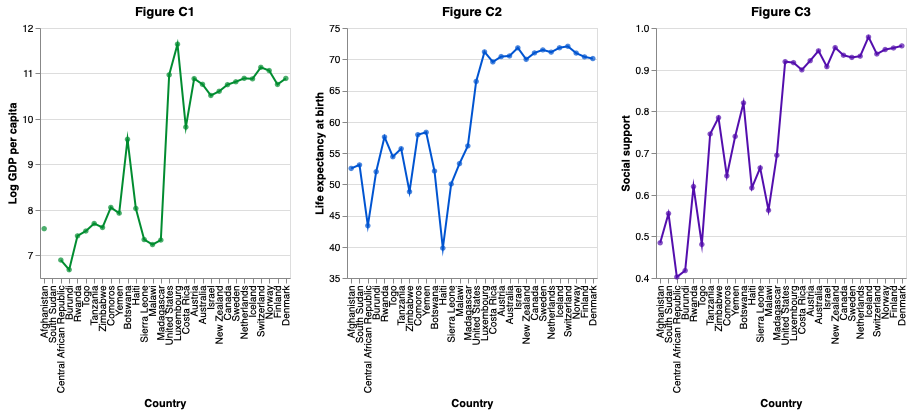

In [12]:
# construct first line plot, gdp per capita by country
fig_c1 = alt.Chart(lh_15.reset_index(), title = 'Figure C1').mark_line(color = '#018c30').encode(
    x = alt.X('Country', sort = alt.EncodingSortField(field = 'Happiness rating', 
                                           order = 'ascending')),
    y = alt.Y('Log GDP per capita', scale = alt.Scale(zero=False))
).properties(
    width = 250,
    height = 250
)

points_1 = alt.Chart(lh_15.reset_index(), title = 'Figure C1').mark_circle(color = '#018c30').encode(
    x = alt.X('Country', sort = alt.EncodingSortField(field = 'Happiness rating', 
                                           order = 'ascending')),
    y = alt.Y('Log GDP per capita', scale = alt.Scale(zero=False))
).properties(
    width = 250,
    height = 250
)

# construct second line plot, life expenctancy by country
fig_c2 = alt.Chart(lh_15.reset_index(), title = 'Figure C2').mark_line(color = '#0054d1').encode(
    x = alt.X('Country', sort = alt.EncodingSortField(field = 'Happiness rating', 
                                           order = 'ascending')),
    y = alt.Y('Life expectancy at birth', scale = alt.Scale(zero=False))
).properties(
    width = 250,
    height = 250
)

points_2 = alt.Chart(lh_15.reset_index(), title = 'Figure C2').mark_circle(color = '#0054d1').encode(
    x = alt.X('Country', sort = alt.EncodingSortField(field = 'Happiness rating', 
                                           order = 'ascending')),
    y = alt.Y('Life expectancy at birth', scale = alt.Scale(zero=False))
).properties(
    width = 250,
    height = 250
)

# construct third line plot, social support by country
fig_c3 = alt.Chart(lh_15.reset_index(), title = 'Figure C3').mark_line(color = '#530ead').encode(
    x = alt.X('Country', sort = alt.EncodingSortField(field = 'Happiness rating', 
                                           order = 'ascending')),
    y = alt.Y('Social support', scale = alt.Scale(zero=False))
).properties(
    width = 250,
    height = 250
)

points_3 = alt.Chart(lh_15.reset_index(), title = 'Figure C2').mark_circle(color = '#530ead').encode(
    x = alt.X('Country', sort = alt.EncodingSortField(field = 'Happiness rating', 
                                           order = 'ascending')),
    y = alt.Y('Social support', scale = alt.Scale(zero=False))
).properties(
    width = 250,
    height = 250
)

# display
(fig_c1 + points_1) | (fig_c2 + points_2) | (fig_c3 + points_3)

By examining Figures C1-C3, we can see that each variable of interest seems to significantly vary between the fifteen lowest rated countries. The variability decreases among the fifteen highest rated countries, possibly implying that lower rated countries' happiness ranks are affected by more than these three factors. If this is the case, it might follow that these variables would have weaker correlations with happiness ratings in these countries. We can test this out by constructing correlation heatmaps once again for each of the two groups.

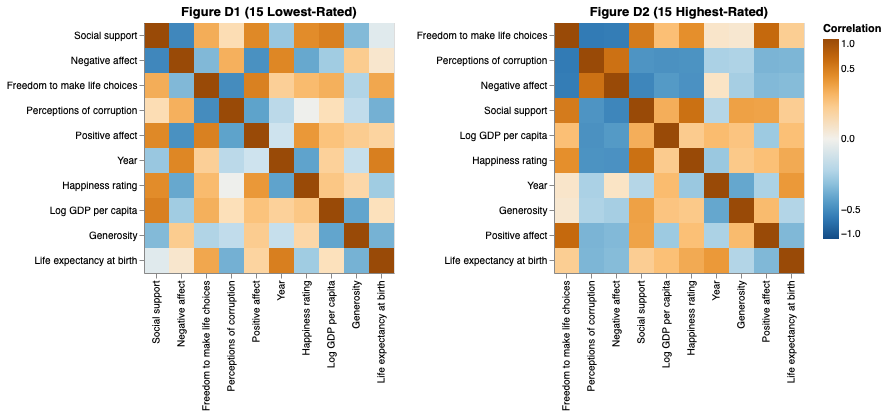

In [13]:
# construct correlation matrix for fifteen lowest-rated
whr_lowest_15 = whr_data.set_index(whr_data.Country).loc[['Afghanistan', 'South Sudan', 'Central African Republic',
                                                          'Burundi','Rwanda', 'Togo', 'Tanzania', 'Zimbabwe',
                                                          'Comoros', 'Yemen', 'Botswana', 'Haiti', 'Sierra Leone', 
                                                          'Malawi', 'Madagascar'], :]
corr_mx1 = whr_lowest_15.drop(columns=['Country']).corr()

# melt corr_mx
corr_mx_long1 = corr_mx1.reset_index().rename(
    columns = {'index': 'row'}
).melt(
    id_vars = 'row',
    var_name = 'col',
    value_name = 'Correlation'
)

# construct correlation heatmap
fig_d1 = alt.Chart(corr_mx_long1, title = 'Figure D1 (15 Lowest-Rated)').mark_rect().encode(
    x = alt.X('col', title = '', sort = {'field': 'Correlation', 'order': 'ascending'}), 
    y = alt.Y('row', title = '', sort = {'field': 'Correlation', 'order': 'ascending'}),
    color = alt.Color('Correlation', 
                      scale = alt.Scale(scheme = 'blueorange', # diverging gradient
                                        domain = (-1, 1), # ensure white = 0
                                        type = 'sqrt'), # adjust gradient scale
                     legend = alt.Legend(tickCount = 5)) # add ticks to colorbar at 0.5 for reference
).properties(width = 250, height = 250)



# construct correlation matrix for fifteen highest-rated
whr_highest_15 = whr_data.set_index(whr_data.Country).loc[['United States', 'Luxembourg', 'Costa Rica', 'Austria',
                                                           'Australia', 'Israel', 'New Zealand', 'Canada', 'Sweden',
                                                           'Netherlands', 'Iceland', 'Switzerland', 'Norway',
                                                           'Finland', 'Denmark'], :]
corr_mx2 = whr_highest_15.drop(columns=['Country']).corr()

# melt corr_mx
corr_mx_long2 = corr_mx2.reset_index().rename(
    columns = {'index': 'row'}
).melt(
    id_vars = 'row',
    var_name = 'col',
    value_name = 'Correlation'
)

# construct correlation heatmap
fig_d2 = alt.Chart(corr_mx_long2, title = 'Figure D2 (15 Highest-Rated)').mark_rect().encode(
    x = alt.X('col', title = '', sort = {'field': 'Correlation', 'order': 'ascending'}), 
    y = alt.Y('row', title = '', sort = {'field': 'Correlation', 'order': 'ascending'}),
    color = alt.Color('Correlation', 
                      scale = alt.Scale(scheme = 'blueorange', # diverging gradient
                                        domain = (-1, 1), # ensure white = 0
                                        type = 'sqrt'), # adjust gradient scale
                     legend = alt.Legend(tickCount = 5)) # add ticks to colorbar at 0.5 for reference
).properties(width = 250, height = 250)

# display
fig_d1 | fig_d2

In [14]:
# inspect happiness rating's individual correlation values with other variables for lowest 15
corr_mx1.loc[:, 'Happiness rating'].sort_values()

Year                           -0.353179
Negative affect                -0.324710
Life expectancy at birth       -0.150807
Perceptions of corruption      -0.000696
Generosity                      0.063269
Log GDP per capita              0.123119
Freedom to make life choices    0.174911
Positive affect                 0.330857
Social support                  0.399199
Happiness rating                1.000000
Name: Happiness rating, dtype: float64

In [15]:
# # inspect happiness rating's individual correlation values with other variables for highest 15
corr_mx2.loc[:, 'Happiness rating'].sort_values()

Negative affect                -0.460828
Perceptions of corruption      -0.452367
Year                           -0.167329
Log GDP per capita              0.105832
Generosity                      0.114889
Positive affect                 0.154350
Life expectancy at birth        0.246396
Freedom to make life choices    0.384333
Social support                  0.581953
Happiness rating                1.000000
Name: Happiness rating, dtype: float64

In general, the fifteen highest-rated countries seem to have stronger, better defined correlations between variables relative to the fifteen lowest-rated countries. However, something that both subsets of the data have in common is that their strongest positive correlation with happiness ratings is social support. It is possible that in focusing on the political and economic characteristics of each country, I have overlooked how much social support influences a respondent's happiness. Figures A-D2 all attest that social support has one of the biggest, if not the biggest, impact on a respondent's happiness rating. 

With this in mind, we can now move towards analyzing the perceptions of corruption mentioned earlier. To accomplish this, I will perform principal component analysis, or PCA, on this dataset to check if any of the major principal components can give some sort of insight on this observation.

In [16]:
# construct matrix and examine loadings
x_mx = whr_data.drop(columns=['Country','Year']).dropna()
pca = PCA(data = x_mx, standardize = True)
pca.loadings

,comp_0,comp_1,comp_2,comp_3,comp_4,comp_5,comp_6,comp_7,comp_8
Happiness rating,0.443544,-0.107710,0.076934,-0.074852,0.030270,-0.219528,0.026782,0.741680,-0.424537
Log GDP per capita,0.397397,-0.375113,0.138024,0.058534,0.118442,0.011478,0.104129,0.149179,0.794752
Social support,0.393455,-0.189181,-0.271101,-0.212935,0.186558,-0.018963,-0.746456,-0.297969,-0.097062
Life expectancy at birth,0.372133,-0.365084,0.287211,-0.035678,0.075563,0.134938,0.462976,-0.508643,-0.384038
Freedom to make life choices,0.337298,0.338298,0.111823,-0.088597,-0.466837,0.718694,-0.095359,0.081815,0.034449
Generosity,0.122678,0.568857,0.324524,-0.142566,0.725179,0.079849,0.022007,-0.015720,0.052133
Perceptions of corruption,-0.277184,-0.269913,-0.268638,-0.746495,0.191295,0.336679,0.199391,0.175424,0.020415
Positive affect,0.300972,0.386196,-0.198559,-0.468106,-0.324711,-0.510679,0.259347,-0.205590,0.161123
Negative affect,-0.236262,-0.136264,0.767875,-0.373903,-0.242258,-0.189909,-0.316703,-0.013135,0.030811


Based on the computed PCA loadings, the first component will be mainly influenced by happiness rating and its strongest correlations. Perceptions of corruption is the most influential on the fourth principal axis, hence we will need to examine at least four principal components. We can start by confirming that four components captures enough variance in the data to analyze it further.

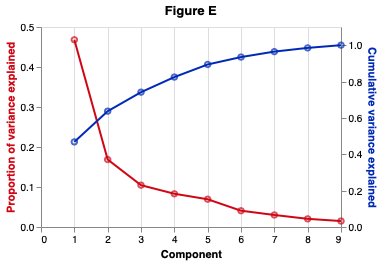

In [18]:
# compute variance ratios
var_ratios = pca.eigenvals/pca.eigenvals.sum()

# store proportion of variance explained as a dataframe
pca_var_explained = pd.DataFrame({
    'Component': np.arange(1, 10),
    'Proportion of variance explained': var_ratios})

# add cumulative sum
pca_var_explained['Cumulative variance explained'] = var_ratios.cumsum()

# encode component axis only as base layer
base = alt.Chart(pca_var_explained, title = 'Figure E').encode(
    x = alt.X('Component', scale=alt.Scale(zero=True))
)

# make a base layer for the proportion of variance explained
prop_var_base = base.encode(
    y = alt.Y('Proportion of variance explained',
              axis = alt.Axis(titleColor = '#cf0614'))
)

# make a base layer for the cumulative variance explained
cum_var_base = base.encode(
    y = alt.Y('Cumulative variance explained', axis = alt.Axis(titleColor = '#002ab5'))
)

# add points and lines to each base layer
prop_var = prop_var_base.mark_line(stroke = '#cf0614') + prop_var_base.mark_point(color = '#cf0614')
cum_var = cum_var_base.mark_line(color = '#002ab5') + cum_var_base.mark_point(color = '#002ab5')

# layer the two layers
var_explained_plot = alt.layer(prop_var, cum_var).resolve_scale(y = 'independent').properties(
    width = 300,
    height = 200
)

# display
var_explained_plot

In [19]:
# number of selected components
num_pc = pca_var_explained[pca_var_explained['Proportion of variance explained'] > 0.08].shape[0]

# variance explained
var_explained = pca_var_explained[pca_var_explained['Proportion of variance explained'] > 0.08][
'Proportion of variance explained'].sum()

#print
print('number selected: ', num_pc)
print('proportion of variance captured: ', var_explained)

number selected:  4
proportion of variance captured:  0.8245335915279052


Roughly 82% of the variance is captured among the first four principal components. Thus, we can examine these four principal axes closer to get a better idea of what each one represents.

In [20]:
# subset loadings
loading_df = pca.loadings.iloc[:, 0:num_pc]

# rename columns
loading_df = loading_df.rename(columns = dict(zip(loading_df.columns, ['PC' + str(i) for i in range(1, num_pc + 1)])))

# melt from wide to long
loading_plot_df = loading_df.reset_index().melt(
    id_vars = 'index',
    var_name = 'Principal Component',
    value_name = 'Loading'
).rename(columns = {'index': 'Variable'})

# add a column of zeros to encode for x = 0 line to plot
loading_plot_df['zero'] = np.repeat(0, len(loading_plot_df))

# create base layer
base = alt.Chart(loading_plot_df)

# create lines + points for loadings
loadings = base.mark_line(point = True).encode(
    y = alt.X('Variable', title = ''),
    x = 'Loading',
    color = 'Principal Component'
)

# create line at zero
rule = base.mark_rule().encode(x = alt.X('zero', title = 'Loading'), size = alt.value(0.05))

# layer
loading_plot = (loadings + rule).properties(height = 200, width = 150)

#display

#### Figure F

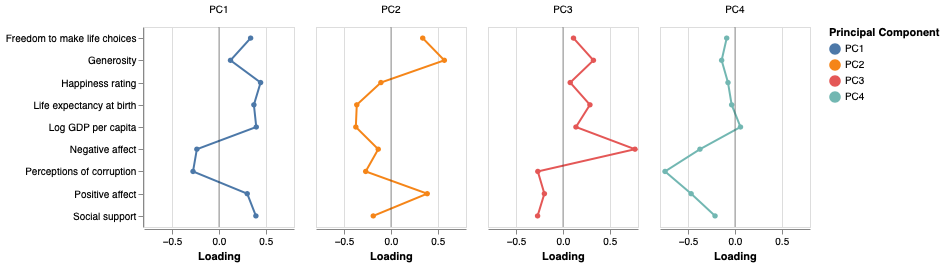

In [21]:
loading_plot.facet(column = alt.Column('Principal Component', title = ''))

As mentioned earlier, PC1 seems to focus on happiness rating and its relationship with other variables in the dataset. PC2 could possibly be a representation of how often a country's respondents tend to commit acts of generosity and how those acts contribute to positive emotions in respondents. PC3 likely serves to represent the causes of negative emotions in respondents. Finally, PC4 resembles respondents' perceptions of corruption and how it affects their lives socially and emotionally.

Ultimately, not much can be said about my observation about the perceptions of corruption variable and its negative correlation with other variables in the dataset other than the fact that as corruption becomes more prominent, all other factors that could affect happiness and a population's well-being dwindle.

## Summary

Through my data exploration and analysis I was able to discover several factors affecting happiness across the world. Social support and log GDP per capita have the biggest influence on respondents' happiness ratings. Both variables covary with happiness rating, in other words, as social support and log GDP per capita increase, so do happiness ratings. My question focused on examining the political and economic state of countries, but through my data analysis I discovered that whether or not a respondent has social support plays a bigger role in their happiness than other factors such as their country's political state. Another interesting thing to note is that ten of the fifteen highest-ranked countries in terms of happiness were located in Europe while twelve of the fifteen lowest-ranked countries were located in Africa. Both of these observations open up discussions as to why this is the case and thinking through this will require research on world history and human nature.